This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [4]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [5]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x188b87f2de0>)

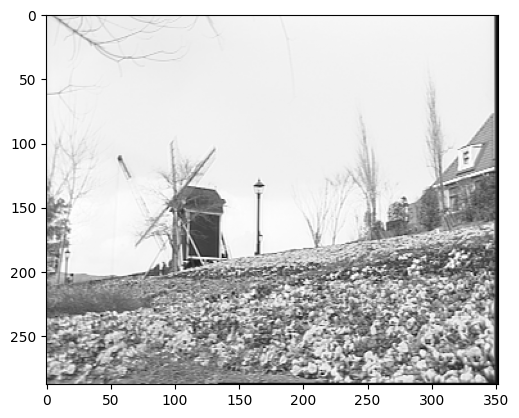

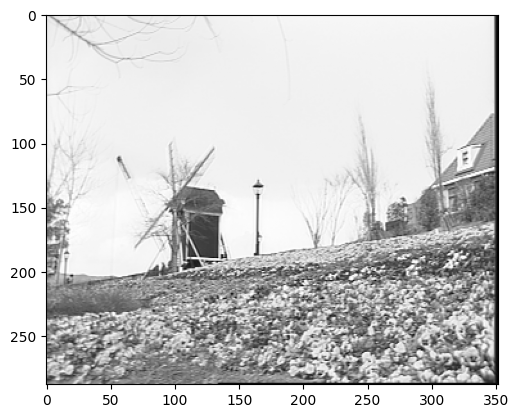

In [6]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [7]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [15]:
def initVector(ref, cur):
    step = 8
    cont = 4 * step
    
    REF = gaussian_filter(ref, 1.) 
    CUR = gaussian_filter(cur, 1.)
    
    CUR = CUR[cont + 1 : (np.shape(CUR)[0] - cont) : step, cont + 1 : (np.shape(CUR)[1] - cont) : step]
    SSDMIN = np.inf
    
    pV = np.zeros(2)
    
    for globR in range(-cont, cont):
        for globC in range(-cont, cont):
            RR = REF[cont + 1 - globR : (cont - globR + np.shape(CUR)[0] * step) : step, 
                     cont + 1 - globC : (cont - globC + np.shape(CUR)[1] * step) : step]
            SSD = np.sum((RR - CUR)**2)
            
            if SSD < SSDMIN:
                SSDMIN = SSD
                pV[0] = globR
                pV[1] = globC
                
    return pV

def computePredictor(r, c, brow, bcol, mvf, ref, cur):
    if r < brow and c < bcol:
        pV = initVector(ref, cur)
    elif r < brow:
        pV = mvf[r, c - bcol, :]
    elif c < bcol:
        pV = mvf[r - brow, c, :]
    else:
        if c >= np.shape(mvf)[1] - bcol:
            vC = mvf[r - brow, c - bcol, :]
        else:
            vC = mvf[r - brow, c + bcol, :]
            
        vA = mvf[r, c - bcol, :]
        vB = mvf[r - brow, c, :]
        temp = np.array([vA, vB, vC]).T
        pV = np.median(temp, axis=1)
        
    return pV.ravel()

def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    extension = search
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur))
    lamb_norm = lamb * brow * bcol
    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))
    
    if lamb == 0.:
        for r in range(0, np.shape(cur)[0], brow):
            for c in range(0, np.shape(cur)[1], bcol):
                B = cur[r : r + brow, c : c + bcol]
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                best_v = [0, 0]
                
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        cost = np.sum((B - ref_block)**2)
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
                            
                mvf[r : r + brow, c : c + bcol, 0] = best_v[0]
                mvf[r : r + brow, c : c + bcol, 1] = best_v[1]
                prediction[r : r + brow, c : c + bcol] = Rbest
    else:
        for r in range(0, np.shape(cur)[0], brow):
            for c in range(0, np.shape(cur)[1], bcol):
                B = cur[r : r + brow, c : c + bcol]
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                best_v = [0, 0]
                
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        ssd = np.sum((B - ref_block)**2)
                        v_error = (drow - pV[0])**2 + (dcol - pV[1])**2
                        cost = ssd + lamb_norm * v_error
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
                
                mvf[r : r + brow, c : c + bcol, 0] = best_v[0]
                mvf[r : r + brow, c : c + bcol, 1] = best_v[1]
                prediction[r : r + brow, c : c + bcol] = Rbest
                
    mvf = -mvf 
    return mvf, prediction

In [16]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

When we display the SSD motion field with 16x16 blocks and a search radius of 8, the global motion is coherent on the flower and the background, but we still see local errors around object contours and in textured regions with repeated patterns. This happens because one vector is shared by a full block, so mixed-motion areas at boundaries are approximated by a single displacement. It also happens when several candidate blocks have very similar SSD values, which can create ambiguous matches.

When we reduce the block size, the field follows local deformations better and contour errors decrease, but the vectors become less regular and more sensitive to noise. When we increase the block size, the field is smoother but less precise near motion discontinuities. Increasing the search radius helps when true motion is larger, but it also increases the risk of false matches and the computation time.

In [17]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

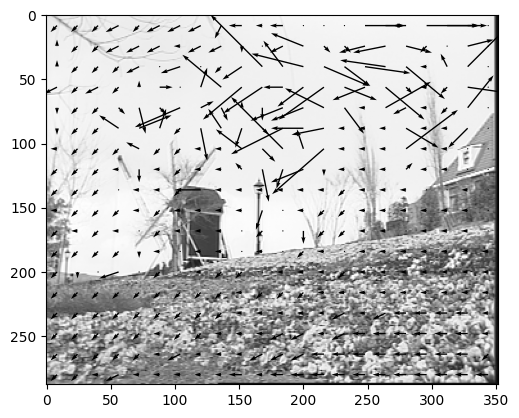

In [18]:
displayMVF(im1,mvf_ssd,brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

The motion-compensated image is globally closer to the second frame than the original reference frame, especially on areas that follow the dominant motion. The remaining errors are mostly located near object edges and around occlusion or uncovering zones, where perfect compensation is not possible with a single backward warp per pixel. Small interpolation artifacts can also appear because the compensated image is reconstructed with sub-pixel interpolation.

In [19]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x188bab221e0>)

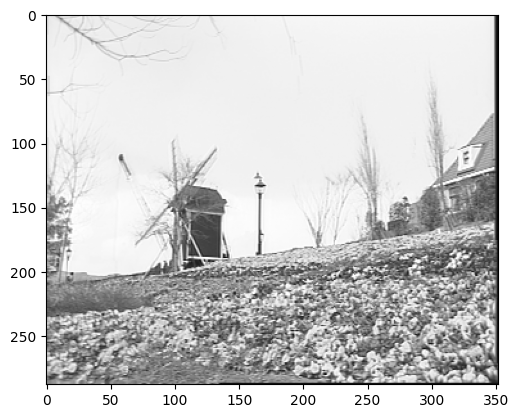

In [20]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

The PSNR function is correctly implemented from the MSE definition. For the current SSD experiment, the displayed PSNR is about 16.46 dB, which confirms that compensation improves similarity compared with a simple frame-to-frame comparison in most practical settings. With different parameters, we usually observe a tradeoff: smaller blocks improve local adaptation but can be noisier, while larger blocks are more stable but less precise at boundaries.

Yes, the PSNR between the motion-compensated image and im2 should be better than between im1 and im2, because motion estimation aligns the structures before measuring the error. The gain is limited in areas with non-translational motion inside blocks, occlusions, interpolation errors, or matching ambiguities.

In [21]:
def PSNR(im1, im2):
    mse = np.mean((im1 - im2) ** 2)
    if mse == 0:
        return 100
    
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    
    return psnr

In [22]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

16.460076383673186


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [23]:
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    extension = search
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur))
    lamb_norm = lamb * brow * bcol
    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))
    
    if lamb == 0.:
        for r in range(0, np.shape(cur)[0], brow):
            for c in range(0, np.shape(cur)[1], bcol):
                B = cur[r : r + brow, c : c + bcol]
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                best_v = [0, 0]
                
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        
                        # Calcul de la SAD (Valeur Absolue)
                        cost = np.sum(np.abs(B - ref_block))
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
                            
                mvf[r : r + brow, c : c + bcol, 0] = best_v[0]
                mvf[r : r + brow, c : c + bcol, 1] = best_v[1]
                prediction[r : r + brow, c : c + bcol] = Rbest
    else:
        for r in range(0, np.shape(cur)[0], brow):
            for c in range(0, np.shape(cur)[1], bcol):
                B = cur[r : r + brow, c : c + bcol]
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                best_v = [0, 0]
                
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        
                        # SAD + Régularisation
                        sad = np.sum(np.abs(B - ref_block))
                        v_error = (drow - pV[0])**2 + (dcol - pV[1])**2
                        cost = sad + lamb_norm * v_error
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
                
                mvf[r : r + brow, c : c + bcol, 0] = best_v[0]
                mvf[r : r + brow, c : c + bcol, 1] = best_v[1]
                prediction[r : r + brow, c : c + bcol] = Rbest
                
    mvf = -mvf 
    return mvf, prediction

In [24]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

The SAD field is very similar to the SSD field on large uniform motions, which is expected because both criteria search for the same displacement. The main difference is robustness: SAD is generally less sensitive to isolated intensity outliers, while SSD penalizes large pixel errors more strongly. In practice here the vectors are close, and the differences appear mostly in difficult local regions where the match is ambiguous.

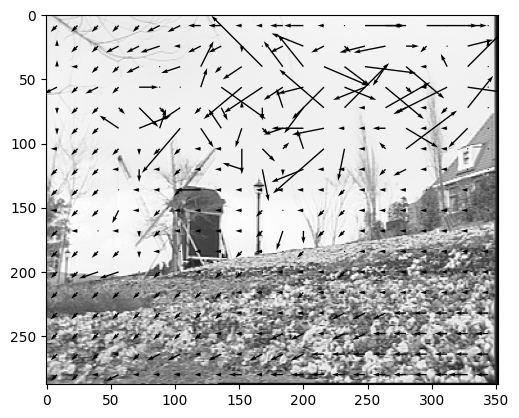

In [25]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

With the provided run, SAD gives a PSNR around 16.40 dB, very close to SSD at about 16.46 dB. This means both criteria perform similarly on this sequence. In general, SSD can produce slightly sharper matching when photometric consistency is good, while SAD can be a bit more robust when there are local intensity deviations.

For field regularity, the block size still has the strongest effect in both methods: larger blocks produce smoother vectors but blur motion details, and smaller blocks capture details better but introduce more local fluctuations.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x188bbdf79e0>)

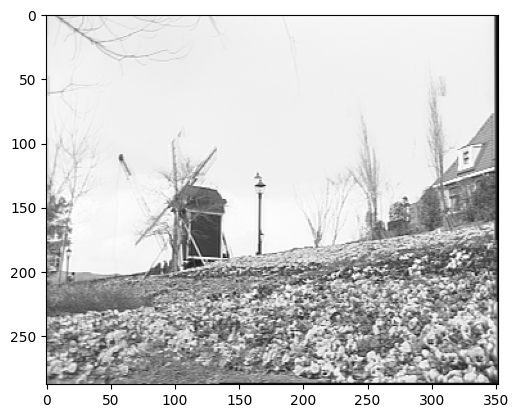

In [ ]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [ ]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

16.39962998394595


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

The regularized SSD-based algorithm is implemented in the me_ssd function when lamb is nonzero. The added term penalizes the distance between the tested displacement and a predictor vector computed from neighboring blocks, so the method favors spatially coherent motion while still fitting image data.

This regularization computes a compromise between data fidelity and motion smoothness. For small lambda, the result stays close to unregularized SSD. For larger lambda, the field becomes smoother and less noisy, but too much regularization can oversmooth true local motion changes and reduce prediction quality around motion boundaries.

In other words, lambda controls the balance between local matching accuracy and vector-field consistency.

### I-2-2- Regularized SAD-based algorithm

In [29]:
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    extension = search
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur))
    lamb_norm = lamb * brow * bcol
    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))
    
    for r in range(0, np.shape(cur)[0], brow):
        for c in range(0, np.shape(cur)[1], bcol):
            B = cur[r : r + brow, c : c + bcol]
            costMin = np.inf
            Rbest = np.zeros((brow, bcol))
            best_v = [0, 0]
            
            if lamb == 0.:
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        cost = np.sum(np.abs(B - ref_block))
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
            else:
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                
                for dcol in range(-search, search + 1):
                    for drow in range(-search, search + 1):
                        ref_block = ref_extended[r + drow + extension : r + drow + extension + brow, 
                                                 c + dcol + extension : c + dcol + extension + bcol]
                        
                        sad = np.sum(np.abs(B - ref_block))
                        v_error = (drow - pV[0])**2 + (dcol - pV[1])**2
                        cost = sad + lamb_norm * v_error
                        
                        if cost < costMin:
                            costMin = cost
                            Rbest = ref_block
                            best_v = [drow, dcol]
            
            mvf[r : r + brow, c : c + bcol, 0] = best_v[0]
            mvf[r : r + brow, c : c + bcol, 1] = best_v[1]
            prediction[r : r + brow, c : c + bcol] = Rbest
            
    mvf = -mvf 
    return mvf, prediction

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [30]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7febada8da10>)

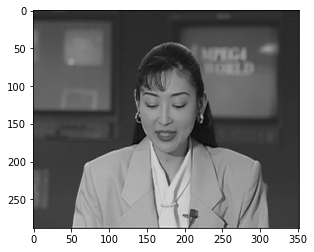

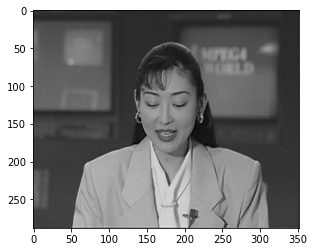

In [7]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [31]:
# 1. On calcule une première estimation grossière avec le Block Matching (SSD ou SAD)
# Cela sert de point de départ pour l'algorithme de Horn-Schunck
mvf_initial, _ = me_ssd(im2, im1, brow, bcol, search_radius)
# Si tu préfères utiliser la SAD régularisée codée avant, tu peux utiliser :
# mvf_initial, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb=10)


def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100, blur = 1.):
    """
    Horn-Schunck optical flow method.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, 'same')
        vAvg = convolve2d(v, kernel_1, 'same')
        
        # Formule de mise à jour de Horn-Schunck
        # On calcule le terme commun pour éviter de le réécrire deux fois
        # common = (fx * u_moy + fy * v_moy + ft) / (alpha^2 + fx^2 + fy^2)
        common = (fx * uAvg + fy * vAvg + ft) / (alpha**2 + fx**2 + fy**2)
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * common
        v = vAvg - fy * common
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

# Paramètres de Horn-Schunck
alpha = 100
ite = 100

# 3. Initialisation et inversion des axes
# Attention : 
# Block Matching (mvf) : index 0 = Lignes (Vertical, v), index 1 = Colonnes (Horizontal, u)
# Optical Flow (u,v)   : u = Horizontal (Colonnes), v = Vertical (Lignes)
uInitial = mvf_initial[:,:,1] 
vInitial = mvf_initial[:,:,0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite, blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

Horn and Schunck usually gives a denser and smoother motion field than block matching, with better continuity in low-texture areas thanks to the global smoothness constraint. On sequences with small and smooth motion such as Akiyo, this often improves visual coherence and can improve PSNR when alpha and iteration count are properly tuned.

On more complex motion such as Flowers, the improvement is not always systematic because a global smoothness prior can oversmooth motion discontinuities and fail in regions with larger or nonuniform displacement. In practice, the best approach is to compare PSNR and visual artifacts while tuning alpha, the number of iterations, and initialization.

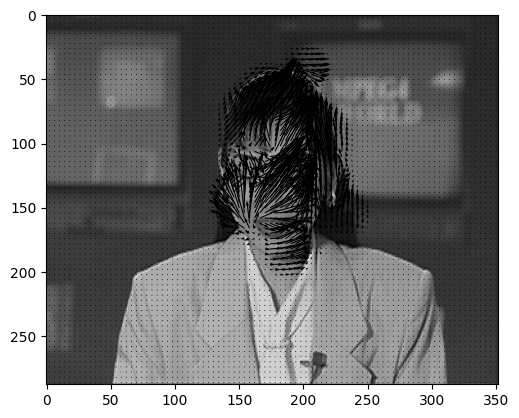

In [32]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [33]:
psnr_hs

np.float64(35.82907640994765)